# Setup

In [ ]:
%%capture
!pip show transformers
!pip show accelerate
!pip install transformers[torch] -U
!pip install accelerate -U
!pip install transformers
!pip install pytorch-lightning
!pip install --upgrade transformers
!pip install datasets

# Preprocessing

In [1]:
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset
from transformers import Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModelForSequenceClassification


# 1. Prepare Dataset
# 2. Load pretrained Tokenizer, call it with dataset -> encoding
# 3. Build PyTorth Dataset with encodings
# 4. Load pretrained Model
# 5. Load HF Trainer and train it

# Train Data - 52662 rows after pre-processing (done above)
toxicity_train_df = pd.read_csv('toxicity_train.csv', on_bad_lines='skip', quoting=csv.QUOTE_NONE)
toxicity_train_df = toxicity_train_df.dropna()

# Test Data - 7287 rows after pre-processing
toxicity_test_df = pd.read_csv('toxicity_test.csv', on_bad_lines='skip', quoting=csv.QUOTE_NONE)
toxicity_test_df = toxicity_test_df.dropna()

# List of categories to check
categories_to_check = ['obscene', 'sexual_explicit', 'threat', 'insult', 'identity_attack']

toxicity_train_df[categories_to_check] = toxicity_train_df[categories_to_check].apply(pd.to_numeric, errors='coerce')
toxicity_test_df[categories_to_check] = toxicity_test_df[categories_to_check].apply(pd.to_numeric, errors='coerce')

# Check if any category is above the 0.25 threshold
toxicity_train_df['toxic'] = (toxicity_train_df[categories_to_check] >= 0.25).any(axis=1).astype(float)
toxicity_test_df['toxic'] = (toxicity_test_df[categories_to_check] >= 0.25).any(axis=1).astype(float)

# # Convert boolean values to 1.0 for True and 0.0 for False
toxicity_train_df['toxic'] = toxicity_train_df['toxic'].astype(float)
toxicity_test_df['toxic'] = toxicity_test_df['toxic'].astype(float)

toxicity_train_df = toxicity_train_df[['comment_text', 'toxic', 'obscene', 'sexual_explicit', 'threat', 'insult', 'identity_attack']]
toxicity_test_df = toxicity_test_df[['comment_text', 'toxic', 'obscene', 'sexual_explicit', 'threat', 'insult', 'identity_attack']]

# print("\nClass distribution in training data before undersampling:")
# print(toxicity_train_df['toxic'].value_counts())

# print("\nClass distribution in test data before undersampling:")
# print(toxicity_test_df['toxic'].value_counts())

sample_rate = 0.99

toxicity_train_df = toxicity_train_df.sample(frac=sample_rate, random_state=42)



# # Fraction of the majority class you want to keep (e.g., 0.2 for 20%)
# undersample_fraction = 0.5

# # Separate the majority and minority classes in training data
# majority_class_train = toxicity_train_df[toxicity_train_df['toxic'] == 0]
# minority_class_train = toxicity_train_df[toxicity_train_df['toxic'] == 1]

# # Undersample the majority class in training data
# undersampled_majority_class_train = majority_class_train.sample(frac=undersample_fraction, random_state=42)

# # Concatenate the undersampled majority class with the minority class in training data
# undersampled_train_df = pd.concat([undersampled_majority_class_train, minority_class_train])

# # Shuffle the undersampled training dataframe
# toxicity_train_df = undersampled_train_df.sample(frac=1, random_state=42).reset_index(drop=True)

# # Separate the majority and minority classes in test data
# majority_class_test = toxicity_test_df[toxicity_test_df['toxic'] == 0]
# minority_class_test = toxicity_test_df[toxicity_test_df['toxic'] == 1]

# # Display the class distribution after undersampling
# print("\nClass distribution in training data after undersampling:")
# print(toxicity_train_df['toxic'].value_counts())

# print("\nClass distribution in test data after undersampling:")
# print(toxicity_test_df['toxic'].value_counts())

# desired_size = 50000

# # Randomly sample rows from the DataFrame
# toxicity_train_df = toxicity_train_df.sample(n=desired_size, random_state=42)

print("Toxic train examples")
print(toxicity_train_df.head(4))

print("Toxic test examples")
print(toxicity_test_df.head(4))

<ipython-input-1-e9bfd4d69005>:20: DtypeWarning: Columns (14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,39,40,41,42,43,44) have mixed types. Specify dtype option on import or set low_memory=False.
  toxicity_train_df = pd.read_csv('toxicity_train.csv', on_bad_lines='skip', quoting=csv.QUOTE_NONE)
<ipython-input-1-e9bfd4d69005>:24: DtypeWarning: Columns (17,18,19,20,21,22,23,24,25,26) have mixed types. Specify dtype option on import or set low_memory=False.
  toxicity_test_df = pd.read_csv('toxicity_test.csv', on_bad_lines='skip', quoting=csv.QUOTE_NONE)


Toxic train examples
                                                     comment_text  toxic  \
762198  0.6                            loving and just God saying    1.0   
4997696 0.0                read a bit more of the New Testament."    0.0   
845762  0.0      and right intention (you may easily look this...    0.0   
671979  0.5875  100 jobs are STILL moving to Mexico. And they ...    1.0   

                obscene  sexual_explicit  threat  insult  identity_attack  
762198  0.6      0.0000           3.0000     0.4   0.200              0.1  
4997696 0.0      0.0000           0.0000     0.0   0.000              0.0  
845762  0.0      0.0000           0.0000     0.0   0.000              0.0  
671979  0.5875   0.5125           0.4625     0.0   0.175              0.0  
Toxic test examples
                                          comment_text  toxic  obscene  \
24                                                BS !    0.0      0.0   
56   Hodad...does your user handle refer to your d

<ipython-input-1-e9bfd4d69005>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  toxicity_test_df[categories_to_check] = toxicity_test_df[categories_to_check].apply(pd.to_numeric, errors='coerce')


Test Lengths of DFs

In [2]:
print(len(toxicity_train_df))
print(len(toxicity_test_df))

25012
7287


# Visualization of toxicity in train

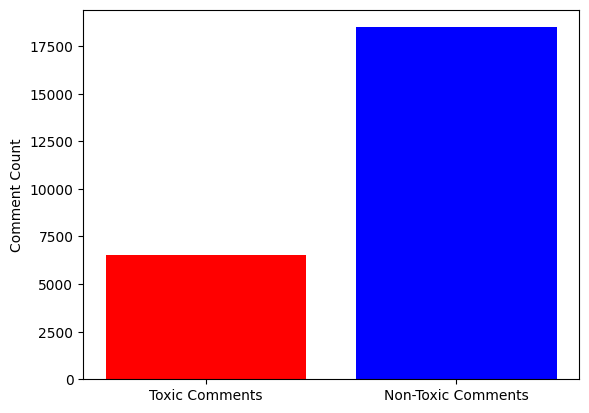

In [3]:
# Count toxic and non-toxic comments
toxic_count = toxicity_train_df['toxic'].sum()
non_toxic_count = len(toxicity_train_df) - toxic_count

# Plot side-by-side bars for toxic and non-toxic comments
labels = ['Toxic Comments', 'Non-Toxic Comments']
counts = [toxic_count, non_toxic_count]

plt.bar(labels, counts, color=['red', 'blue'])
plt.ylabel('Comment Count')

plt.show()

# Visualization of toxicity in test

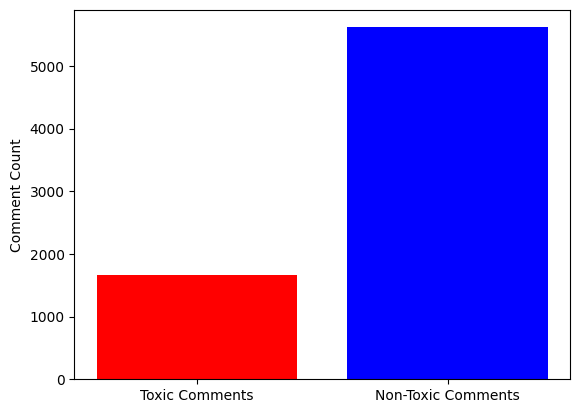

In [4]:
# Count toxic and non-toxic comments
toxic_count = toxicity_test_df['toxic'].sum()
non_toxic_count = len(toxicity_test_df) - toxic_count

# Plot side-by-side bars for toxic and non-toxic comments
labels = ['Toxic Comments', 'Non-Toxic Comments']
counts = [toxic_count, non_toxic_count]

plt.bar(labels, counts, color=['red', 'blue'])
plt.ylabel('Comment Count')

plt.show()

# Splitting and Labelling

In [5]:
model_name = "roberta-base"

# Reset index to ensure consistency
toxicity_train_df.reset_index(drop=True, inplace=True)
toxicity_test_df.reset_index(drop=True, inplace=True)

# Select relevant columns from DataFrame and drop NaN values
train_data = toxicity_train_df[['comment_text', 'toxic']].dropna()
test_data = toxicity_test_df[['comment_text', 'toxic']].dropna()

# Extract features and labels
train_texts = train_data['comment_text'].tolist()
train_labels = train_data['toxic'].tolist()
test_texts = test_data['comment_text'].tolist()
test_labels = test_data['toxic'].tolist()

# Print examples of texts & labels
print("train_texts:")
print(train_texts[:5])
print("train_labels:")
print(train_labels[:5])
print("test_texts")
print(test_texts[:5])
print("test_labels:")
print(test_labels[:5])

# Split train data into train and validation sets
train_texts, val_texts, train_labels, val_labels = train_test_split(train_texts, train_labels, test_size=0.2)


train_texts:
[' loving and just God saying', ' read a bit more of the New Testament."', ' and right intention (you may easily look this up online). Since there was no reason to suspect that matter or form were lacking', '100 jobs are STILL moving to Mexico. And they got a $7 million tax break on top of it. I wonder how much unemployed benefits that $7 million could have paid for?"', ' or just being human."']
train_labels:
[1.0, 0.0, 0.0, 1.0, 1.0]
test_texts
['BS !', 'Hodad...does your user handle refer to your daughter??', "Many of them were wearing red Na'i Aupuni shirts.  Does that not show support for federal recognition?", '"Methinks your comment is indicative of your need to understand the Christian faith which does not require the subservience of woman as much as care and love for them by the man - ""as Christ loved the church""."', "And sometimes it's just salting the earth..."]
test_labels:
[0.0, 0.0, 0.0, 0.0, 0.0]


# Dataset

In [6]:
from torch.utils.data import Dataset, DataLoader
from transformers import RobertaTokenizer, RobertaModel


class ToxicDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx]).float()
        return item

    def __len__(self):
        return len(self.labels)

tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
train_encodings = tokenizer(train_texts, truncation=True, padding=True)
val_encodings = tokenizer(val_texts, truncation=True, padding=True)
test_encodings = tokenizer(test_texts, truncation=True, padding=True)

train_dataset = ToxicDataset(train_encodings, train_labels)
val_dataset = ToxicDataset(val_encodings, val_labels)
test_dataset = ToxicDataset(test_encodings, test_labels)

print("Train Dataset")
# Iterate over train_dataset and print some samples
for i in range(2):  # Print first 2 samples
    sample = train_dataset[i]
    print(f"Sample {i + 1}:")
    # Convert input_ids tensor to list and access its keys
    encoding_keys = tokenizer.convert_ids_to_tokens(sample["input_ids"].tolist())
    print("Encoding keys:", encoding_keys)  # Print keys of encoding
    print("Label:", sample["labels"].item())  # Print label
    print()

print("Val Dataset")
# Iterate over val dataset and print some samples
for i in range(2):  # Print first 2 samples
    sample = val_dataset[i]
    print(f"Sample {i + 1}:")
    # Convert input_ids tensor to list and access its keys
    encoding_keys = tokenizer.convert_ids_to_tokens(sample["input_ids"].tolist())
    print("Encoding keys:", encoding_keys)  # Print keys of encoding
    print("Label:", sample["labels"].item())  # Print label
    print()

print("Test Dataset")
# Iterate over test dataset and print some samples
for i in range(2):  # Print first 2 samples
    sample = test_dataset[i]
    print(f"Sample {i + 1}:")
    # Convert input_ids tensor to list and access its keys
    encoding_keys = tokenizer.convert_ids_to_tokens(sample["input_ids"].tolist())
    print("Encoding keys:", encoding_keys)  # Print keys of encoding
    print("Label:", sample["labels"].item())  # Print label
    print()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

Train Dataset
Sample 1:
Encoding keys: ['<s>', 'Ġour', 'Ġgeneration', 'Ġhas', 'Ġnever', 'Ġseem', 'Ġthem', 'Ġfull', 'Ġforce', '."', '</s>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>

# Native PyTorch (instead of HF Trainer)

In [8]:
from torch.utils.data import DataLoader
from transformers import RobertaTokenizer, AutoModelForSequenceClassification
from transformers import AdamW
import torch
import random

random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model = AutoModelForSequenceClassification.from_pretrained('roberta-base', num_labels=1)
model.to(device)
model.train()

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

optim = AdamW(model.parameters(), lr=1e-5)

num_train_epochs = 1
for epoch in range(num_train_epochs):
  total_loss = 0.0
  for batch_idx, batch in enumerate(train_loader):
      optim.zero_grad()
      input_ids = batch['input_ids'].to(device)
      attention_mask = batch['attention_mask'].to(device)
      labels = batch['labels'].to(device)

      outputs = model(input_ids, attention_mask=attention_mask, labels=labels)

      loss = outputs[0]
      total_loss += loss.item()

      loss.backward()
      optim.step()

      if (batch_idx + 1) % 20 == 0:  # Print progress every 20 batches
          print(f"Epoch [{epoch + 1}/{num_train_epochs}], Batch [{batch_idx + 1}/{len(train_loader)}], Loss: {total_loss / (batch_idx + 1):.4f}")

  print(f"Epoch [{epoch + 1}/{num_train_epochs}], Average Loss: {total_loss / len(train_loader):.4f}")

model.eval()

model.save_pretrained('/usr/fine_tuned_roberta_model')

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch [1/1], Batch [20/1251], Loss: 0.2397
Epoch [1/1], Batch [40/1251], Loss: 0.2122
Epoch [1/1], Batch [60/1251], Loss: 0.2038
Epoch [1/1], Batch [80/1251], Loss: 0.2012
Epoch [1/1], Batch [100/1251], Loss: 0.2002
Epoch [1/1], Batch [120/1251], Loss: 0.1998
Epoch [1/1], Batch [140/1251], Loss: 0.2013
Epoch [1/1], Batch [160/1251], Loss: 0.1998
Epoch [1/1], Batch [180/1251], Loss: 0.2020
Epoch [1/1], Batch [200/1251], Loss: 0.2007
Epoch [1/1], Batch [220/1251], Loss: 0.1993
Epoch [1/1], Batch [240/1251], Loss: 0.1983
Epoch [1/1], Batch [260/1251], Loss: 0.1997
Epoch [1/1], Batch [280/1251], Loss: 0.1994
Epoch [1/1], Batch [300/1251], Loss: 0.1983
Epoch [1/1], Batch [320/1251], Loss: 0.1984
Epoch [1/1], Batch [340/1251], Loss: 0.1975
Epoch [1/1], Batch [360/1251], Loss: 0.1976
Epoch [1/1], Batch [380/1251], Loss: 0.1971
Epoch [1/1], Batch [400/1251], Loss: 0.1966
Epoch [1/1], Batch [420/1251], Loss: 0.1968
Epoch [1/1], Batch [440/1251], Loss: 0.1954
Epoch [1/1], Batch [460/1251], Loss:

In [17]:
from google.colab import files

# Paste the path you copied as the argument to files.download()

from tqdm import tqdm
from google.colab import files

# File paths to download
file_paths = ['/usr/fine_tuned_roberta_model_2/config.json', '/usr/fine_tuned_roberta_model_2/model.safetensors']

# Loop through each file and download with tqdm progress bar
for file_path in file_paths:
    with open(file_path, 'wb') as f:
        with tqdm(unit='B', unit_scale=True, unit_divisor=1024, miniters=1,
                  desc=file_path.split('/')[-1]) as pbar:
            # Download the file
            files.download(file_path)
            # Manually update progress bar
            pbar.update()

config.json: 0.00B [00:00, ?B/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

config.json: 1.00B [00:00, 87.4B/s]
model.safetensors: 0.00B [00:00, ?B/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

model.safetensors: 1.00B [00:00, 155B/s]


In [ ]:
# from better_profanity import profanity
# model = AutoModelForSequenceClassification.from_pretrained('/usr/fine_tuned_roberta_model')
# model.to(device)

# test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# # Assuming you have a validation DataLoader named val_loader
# num_toxic_correct = 0
# num_non_toxic_correct = 0
# total = 0
# global count
# global sub_mention
# # global profanity
# sub_mention = False
# profanity_in = False

# with torch.no_grad():
#     for batch in test_loader:
#         input_ids = batch['input_ids'].to(device)
#         attention_mask = batch['attention_mask'].to(device)
#         labels = batch['labels'].to(device)
#         # print(input_ids)
#         # print(attention_mask)
#         # print(labels)

#         outputs = model(input_ids, attention_mask=attention_mask)

#         predictions = torch.sigmoid(outputs.logits).squeeze()  # Assuming binary classification and using sigmoid activation
#         predicted_labels = (predictions >= 0.555).float()

#         num_toxic_correct += ((predicted_labels == 1) & (labels == 1)).sum().item()
#         num_non_toxic_correct += ((predicted_labels == 0) & (labels == 0)).sum().item()
#         total += labels.size(0)

# accuracy_toxic = num_toxic_correct / total
# accuracy_non_toxic = num_non_toxic_correct / total

# print("Total comments observed: ", total)
# print("Accuracy for toxic comments:", accuracy_toxic)
# print("Accuracy for non-toxic comments:", accuracy_non_toxic)

# Default RoBERTa test as baseline

In [10]:
import pandas as pd
import numpy as np
from transformers import RobertaTokenizer, AutoModelForSequenceClassification
import torch
import random

# Set a fixed state for randomness
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)  # If using CUDA

# Load the tokenizer and model for inference
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
model = AutoModelForSequenceClassification.from_pretrained('roberta-base')


# Move the model to CPU if it's on CUDA device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

# Put the model in evaluation mode
model.eval()

# Function to convert LABEL_0 to 'no'
def convert_label(prediction):
    return 'no' if prediction[0]['label'] == 'LABEL_0' else 'yes'

global count
count = 0

def predict_label(row):
    global count
    text_to_predict = row['comment']

    encoding = tokenizer(text_to_predict, return_tensors='pt', padding=True, truncation=True)
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)
    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
    logits = outputs.logits
    probabilities = torch.sigmoid(logits).cpu().numpy().flatten()
    # if(count <100):
    #   print(probabilities)
    # Convert probabilities to binary labels
    # probs[0] < 0.5425 && abs <= 0.061
    binary_label = 1 if ((np.abs(probabilities[1] - probabilities[0]) <= 0.061) and (probabilities[0] < 0.5425)) else 0
    count = count + 1
    if (count % 500 == 0):
      print(count)
    if(count < 90):
      print(text_to_predict)
      print(probabilities)
      print(np.abs(probabilities[1] - probabilities[0]))
      print(binary_label)
    # if (binary_label == 1):
    #   print(text_to_predict)
    return binary_label

# Load the Twitch dataset
twitch_df = pd.read_csv('hasan_abi_11.19.22_test.csv')
print(len(twitch_df))

# Apply the prediction function to each row in the DataFrame
twitch_df['base_prediction'] = twitch_df.apply(predict_label, axis=1)

# Assuming 'LABEL_0' corresponds to 'no'
prediction_counts = twitch_df['base_prediction'].value_counts()
print(prediction_counts)

# Print the counts
print("Count of 'no':", prediction_counts[0.0])
print("Count of 'yes':", prediction_counts[1.0])  # Adjust the label if needed

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


17480
Drake STUNLOCK FREE SATURDAY Drake NO 31 YEAR OLD MAN YELLING AT TROLLS Drake ONLY FUN REACTS AND GAMES Drake 󠀀
[0.5442923 0.4839227]
0.06036958
0
@HORSTBEFEHL D: how dare u call smol bear a stinky
[0.5444405  0.48365706]
0.060783446
0
LETSGO REFRESH LETSGO REFRESH LETSGO REFRESH LETSGO REFRESH LETSGO REFRESH LETSGO REFRESH LETSGO REFRESH LETSGO REFRESH
[0.5396395  0.48169026]
0.057949215
1
SHE BE JEJING MY JUPI Jupijej Jupijej Jupijej
[0.54397565 0.4818541 ]
0.06212154
0
peepoHey Hey Chat I hope you're having a great weekend peepoKiss
[0.5432137  0.48295513]
0.060258597
0
I hope everyone is having a great day hasL
[0.54412186 0.48303255]
0.061089307
0
@elhijodejackslid if you ever see me say live, I'm not trolling :P
[0.5453038  0.48268464]
0.06261918
0
SHE  BE JEJING MY JUPI Jupijej Jupijej Jupijej
[0.54361254 0.48146766]
0.062144876
0
Was not expecting to be here so soon
[0.54455703 0.48294452]
0.061612517
0
LEFTERS STRIMMER LIVE LEFTERS STRIMMER LIVE LEFTERS STRIMMER LIVE LEF

# Base Toxic Word Cloud

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17480 entries, 0 to 17479
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   user             17480 non-null  object
 1   comment          17480 non-null  object
 2   base_prediction  17480 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 409.8+ KB
None
2     LETSGO REFRESH LETSGO REFRESH LETSGO REFRESH L...
9     LEFTERS STRIMMER LIVE LEFTERS STRIMMER LIVE LE...
11    LEFTERS ANY LEFTERS? LEFTERS ANY LEFTERS? LEFT...
35    LEFTERS LIBBERS HOGGERS LIBS ARE THE TRUE CENT...
36    nesuaLove RUSTY OHIO RAID nesuaFeet RUSTY OHIO...
Name: comment, dtype: object


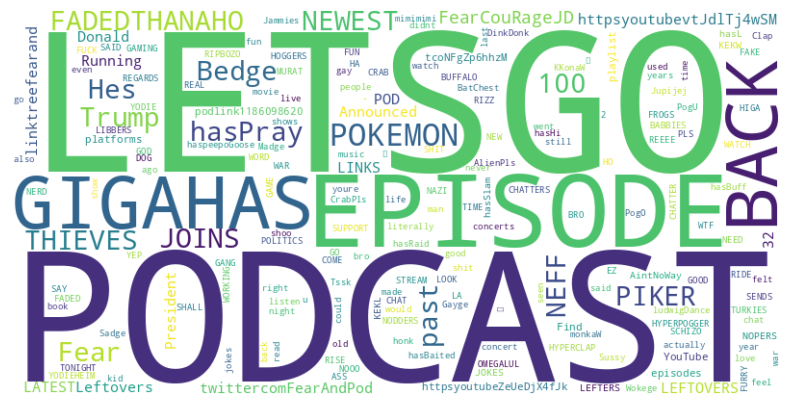

In [11]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import nltk
import pandas as pd
import string

# Download NLTK resources (run only once)
nltk.download('stopwords')
nltk.download('punkt')

print(twitch_df.info())

# Filter toxic comments
toxic_comments = twitch_df[twitch_df['base_prediction'] == 1]['comment']
print(toxic_comments.head(5))

# Initialize NLTK stop words
stop_words = set(stopwords.words('english'))

# Extend the stop words list with additional common words to exclude
additional_stop_words = ['today', "don't", 'like', 'know', 'and', 'the',
                         'get', 'HasanAbi', 'hasanabi', 'Hasan', 'hasan', 'Abi',
                         'dont', ',', 'got', 'cant', 'make',
                         'see', 'im', 'make', 'think', 'one', 'every',
                         'take', 'day', 'really', 'Tier', 'tier', 'Tier 1',
                         '1', 'Theyve', 'theyve', 'going', 'subscribed', 'months']  # Add more words as needed
stop_words.update(additional_stop_words)

# Remove punctuation from comments
def remove_punctuation(text):
    return ''.join([char for char in text if char not in string.punctuation])

cleaned_comments = ' '.join([comment for comment in toxic_comments])
cleaned_comments = remove_punctuation(cleaned_comments)

# Tokenize the cleaned comments
tokens = nltk.word_tokenize(cleaned_comments)

# Remove stop words
tokens = [word for word in tokens if word.lower() not in stop_words]

# Calculate word frequencies
freq_dist = nltk.FreqDist(tokens)

# Generate the word cloud with frequencies
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(freq_dist)

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


In [13]:
!pip install better-profanity

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.1/46.1 kB 885.9 kB/s eta 0:00:00


# Fine-Tuned Roberta on Wikipedia Dataset

In [22]:
import pandas as pd
import numpy as np
from transformers import RobertaTokenizer, AutoModelForSequenceClassification
import torch
import random
from better_profanity import profanity

# Set a fixed state for randomness
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)  # If using CUDA

# Load the tokenizer and model for inference
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
model = AutoModelForSequenceClassification.from_pretrained('/usr/fine_tuned_roberta_model')

# Move the model to CPU if it's on CUDA device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

# Put the model in evaluation mode
model.eval()

# Function to convert LABEL_0 to 'no'
def convert_label(prediction):
    return 'no' if prediction[0]['label'] == 'LABEL_0' else 'yes'

def contains_profanity(text):
    return profanity_check.predict([text])[0]

global count
global sub_mention
# global profanity
sub_mention = False
profanity_in = False
count = 0

def predict_label(row):
    global count
    global sub_mention
    # global profanity
    text_to_predict = row['comment']
    sub_mention = any(keyword in text_to_predict for keyword in ["Tier 1", "subscribed with Prime", "subbed using Prime"])
    profanity_in = profanity.contains_profanity(text_to_predict)
    # if(count <100):
    #   print(text_to_predict)
    encoding = tokenizer(text_to_predict, return_tensors='pt', padding=True, truncation=True)
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)
    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
    logits = outputs.logits
    probabilities = torch.sigmoid(logits).cpu().numpy().flatten()
    # if(count <100):
    #   print(probabilities)
    # Convert probabilities to binary labels
    # < 0.545 or > 0.6 should get flagged as TOXIC
    binary_label = 1 if profanity_in or (np.abs(probabilities[0]) > 0.57418 and np.abs(probabilities[0]) < 0.57422 and not sub_mention)else 0
    count = count + 1
    if (count % 500 == 0):
      print(count)
    if(count < 90):
      print(np.abs(probabilities[0]))
      print(text_to_predict)
      print(binary_label)
    # if (binary_label == 1):
    #   print(text_to_predict)
    # print(binary_label)
    return binary_label

# Load the Twitch dataset
twitch_df = pd.read_csv('hasan_abi_11.19.22_test.csv')
print(len(twitch_df))

# Apply the prediction function to each row in the DataFrame
twitch_df['roberta_wiki_prediction'] = twitch_df.apply(predict_label, axis=1)

# Display the DataFrame with predictions
# print(twitch_df[['comment', 'roberta_wiki_prediction']])

# Assuming 'LABEL_0' corresponds to 'no'
prediction_counts = twitch_df['roberta_wiki_prediction'].value_counts()
print(prediction_counts)

# Print the counts
print("Count of 'no':", prediction_counts[0.0])
print("Count of 'yes':", prediction_counts[1.0])  # Adjust the label if needed

17480
0.57418275
Drake STUNLOCK FREE SATURDAY Drake NO 31 YEAR OLD MAN YELLING AT TROLLS Drake ONLY FUN REACTS AND GAMES Drake 󠀀
1
0.57422507
@HORSTBEFEHL D: how dare u call smol bear a stinky
0
0.55770844
LETSGO REFRESH LETSGO REFRESH LETSGO REFRESH LETSGO REFRESH LETSGO REFRESH LETSGO REFRESH LETSGO REFRESH LETSGO REFRESH
0
0.5622123
SHE BE JEJING MY JUPI Jupijej Jupijej Jupijej
0
0.57421374
peepoHey Hey Chat I hope you're having a great weekend peepoKiss
1
0.57414454
I hope everyone is having a great day hasL
0
0.5741978
@elhijodejackslid if you ever see me say live, I'm not trolling :P
1
0.5582776
SHE  BE JEJING MY JUPI Jupijej Jupijej Jupijej
0
0.5741547
Was not expecting to be here so soon
0
0.5740595
LEFTERS STRIMMER LIVE LEFTERS STRIMMER LIVE LEFTERS STRIMMER LIVE LEFTERS STRIMMER LIVE LEFTERS STRIMMER LIVE LEFTERS STRIMMER LIVE LEFTERS STRIMMER LIVE LEFTERS STRIMMER LIVE LEFTERS STRIMMER LIVE LEFTERS STRIMMER LIVE
0
0.57419735
SEE YOU ON THE OTHER SIDE OFFLINERS hasL hasL hasL

Save Predictions for Fine-Tuned Wikipedia Model

In [23]:
# Define the file path for the Excel file
excel_file_path = "/usr/roberta_wiki_predictions.xlsx"

# Save the 'roberta_wiki_prediction' column to an Excel file
twitch_df['roberta_wiki_prediction'].to_excel(excel_file_path, index=False)

# Fine-Tuned Wikipedia Toxic Word Cloud

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


0     Drake STUNLOCK FREE SATURDAY Drake NO 31 YEAR ...
4     peepoHey Hey Chat I hope you're having a great...
6     @elhijodejackslid if you ever see me say live,...
10    SEE YOU ON THE OTHER SIDE OFFLINERS hasL hasL ...
13    Drake STUNLOCK FREE SATURDAY Drake NO 31 YEAR ...
Name: comment, dtype: object


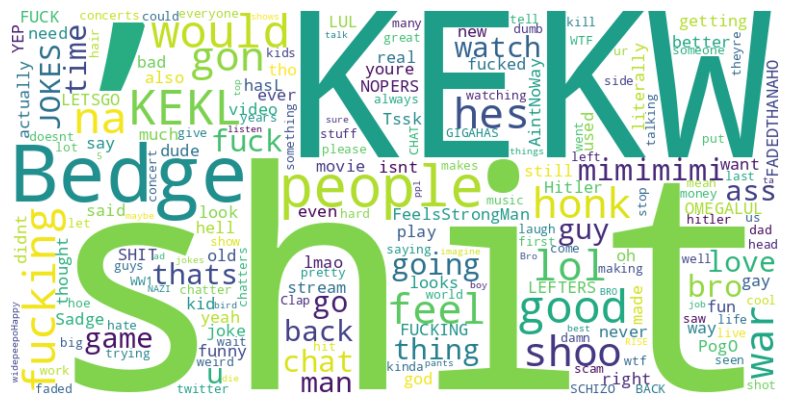

In [26]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import nltk
import pandas as pd
import string

# Download NLTK resources (run only once)
nltk.download('stopwords')
nltk.download('punkt')

# Filter toxic comments
toxic_comments = twitch_df[twitch_df['roberta_wiki_prediction'] == 1]['comment']
print(toxic_comments.head(5))

batch_size = 1000  # Set the batch size
num_rows = len(twitch_df)
with open('union_output.txt', 'w') as f:
    for start in range(0, num_rows, batch_size):
        end = min(start + batch_size, num_rows)
        for index, row in twitch_df.iloc[start:end].iterrows():
            f.write(str(row['roberta_wiki_prediction']) + '\n')

# from google.colab import files
# files.download('union_output.txt')

# Initialize NLTK stop words
stop_words = set(stopwords.words('english'))

# Extend the stop words list with additional common words to exclude
additional_stop_words = ['today', "don't", 'like', 'know', 'and', 'the',
                         'get', 'HasanAbi', 'hasanabi', 'Hasan', 'hasan', 'Abi',
                         'dont', ',', 'got', 'cant', 'make',
                         'see', 'im', 'make', 'think', 'one', 'every',
                         'take', 'day', 'really']  # Add more words as needed
stop_words.update(additional_stop_words)

# Remove punctuation from comments
def remove_punctuation(text):
    return ''.join([char for char in text if char not in string.punctuation])

cleaned_comments = ' '.join([comment for comment in toxic_comments])
cleaned_comments = remove_punctuation(cleaned_comments)

# Tokenize the cleaned comments
tokens = nltk.word_tokenize(cleaned_comments)

# Remove stop words
tokens = [word for word in tokens if word.lower() not in stop_words]

# Calculate word frequencies
freq_dist = nltk.FreqDist(tokens)

# Generate the word cloud with frequencies
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(freq_dist)

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


# Wordcloud without Trump Podcast comment spammed

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


3     Dont forget to check ur cocks before stream st...
9     got here before the notif, yikes I have a problem
12    @rythympnxa naber agam @HasanAbi izlemeye mi g...
15    Just got out the mental hospital missed this s...
17    @abyssabyss2445 LEFTOVERS PODCAST LATEST EPISO...
Name: comment_text, dtype: object


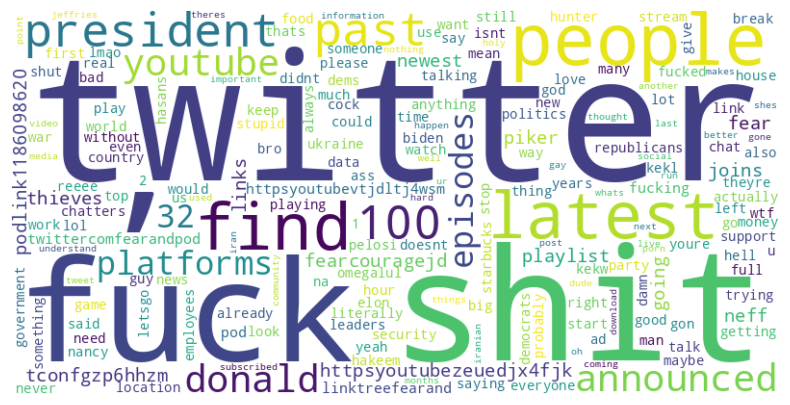

In [69]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import nltk
import pandas as pd
import string

# Download NLTK resources (run only once)
nltk.download('stopwords')
nltk.download('punkt')

# Filter toxic comments
toxic_comments = twitch_df[twitch_df['union_prediction'] == 1]['comment_text']
print(toxic_comments.head(5))

# batch_size = 1000  # Set the batch size
# num_rows = len(twitch_df)
# with open('union_output.txt', 'w') as f:
#     for start in range(0, num_rows, batch_size):
#         end = min(start + batch_size, num_rows)
#         for index, row in twitch_df.iloc[start:end].iterrows():
#             f.write(str(row['union_prediction']) + '\n')

# Initialize NLTK stop words
stop_words = set(stopwords.words('english'))

# Extend the stop words list with additional common words to exclude
additional_stop_words = ['today', "don't", 'like', 'know', 'and', 'the',
                         'get', 'HasanAbi', 'hasanabi', 'Hasan', 'hasan', 'Abi',
                         'dont', ',', 'got', 'cant', 'make', 'hes', 'back',
                         'see', 'im', 'make', 'think', 'one', 'every', 'running',
                         'take', 'day', 'really', 'Trump', 'EPISODE', 'PODCAST', 'Episode',
                         'Podcast', 'leftovers', 'trump', 'episode', 'podcast']  # Add more words as needed
stop_words.update(additional_stop_words)

# Remove punctuation from comments
def remove_punctuation(text):
    return ''.join([char for char in text if char not in string.punctuation])

cleaned_comments = ' '.join([comment for comment in toxic_comments])
cleaned_comments = remove_punctuation(cleaned_comments)

# Convert all words to lowercase before removing stopwords
tokens = [word.lower() for word in tokens]

# Remove stop words
tokens = [word for word in tokens if word not in stop_words]

# Calculate word frequencies
freq_dist = nltk.FreqDist(tokens)

# Generate the word cloud with frequencies
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(freq_dist)

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


# Preprocessing on Twitch Union dataset

In [32]:
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset
from transformers import Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModelForSequenceClassification


# 1. Prepare Dataset
# 2. Load pretrained Tokenizer, call it with dataset -> encoding
# 3. Build PyTorth Dataset with encodings
# 4. Load pretrained Model
# 5. Load HF Trainer and train it

# Train Data (Roberta + Llama Union), 11449 rows
toxicity_train_df = pd.read_csv('/toxic_union.csv',  on_bad_lines='skip')
toxicity_train_df = toxicity_train_df.dropna()

# Test Data - 7287 rows after pre-processing
toxicity_test_df = pd.read_csv('toxicity_test.csv', on_bad_lines='skip', quoting=csv.QUOTE_NONE)
toxicity_test_df = toxicity_test_df.dropna()

# Train Data - 52662 rows after pre-processing (done above)
# toxicity_train_df = pd.read_csv('toxicity_train.csv', on_bad_lines='skip', quoting=csv.QUOTE_NONE)

# List of categories to check
categories_to_check = ['obscene', 'sexual_explicit', 'threat', 'insult', 'identity_attack']

# toxicity_train_df[categories_to_check] = toxicity_train_df[categories_to_check].apply(pd.to_numeric, errors='coerce')
toxicity_test_df[categories_to_check] = toxicity_test_df[categories_to_check].apply(pd.to_numeric, errors='coerce')

# # Check if any category is above the 0.33 threshold
# toxicity_train_df['toxic'] = (toxicity_train_df[categories_to_check] >= 0.25).any(axis=1).astype(float)
toxicity_test_df['toxic'] = (toxicity_test_df[categories_to_check] >= 0.25).any(axis=1).astype(float)

# # Convert boolean values to 1.0 for True and 0.0 for False
# toxicity_train_df['toxic'] = toxicity_train_df['toxic'].astype(float)
toxicity_test_df['toxic'] = toxicity_test_df['toxic'].astype(float)

# toxicity_train_df = toxicity_train_df[['comment_text', 'toxic', 'obscene', 'sexual_explicit', 'threat', 'insult', 'identity_attack']]
toxicity_test_df = toxicity_test_df[['comment_text', 'toxic', 'obscene', 'sexual_explicit', 'threat', 'insult', 'identity_attack']]


print("Toxic train examples")
print(toxicity_train_df.head(4))

print("Toxic test examples")
print(toxicity_test_df.head(4))

<ipython-input-32-64ef2d842ab0>:24: DtypeWarning: Columns (17,18,19,20,21,22,23,24,25,26) have mixed types. Specify dtype option on import or set low_memory=False.
  toxicity_test_df = pd.read_csv('toxicity_test.csv', on_bad_lines='skip', quoting=csv.QUOTE_NONE)


Toxic train examples
                                        comment_text  toxic  llama  union
0  Confused why people are spamming things like J...      0      0      0
1       Nice thats my first time in Hasan Lifestream      0      1      1
2     THE ONE PIECE IS REAL LETSGO NEWS TODAY LETSGO      0      0      0
3  Dont forget to check ur cocks before stream st...      0      0      0
Toxic test examples
                                          comment_text  toxic  obscene  \
24                                                BS !    0.0      0.0   
56   Hodad...does your user handle refer to your da...    0.0      0.0   
156  Many of them were wearing red Na'i Aupuni shir...    0.0      0.0   
181  "Methinks your comment is indicative of your n...    0.0      0.0   

     sexual_explicit    threat  insult  identity_attack  
24               0.0  0.000000     0.0              0.0  
56               0.0  0.000000     0.0              0.0  
156              0.0  0.000000     0.0      

<ipython-input-32-64ef2d842ab0>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  toxicity_test_df[categories_to_check] = toxicity_test_df[categories_to_check].apply(pd.to_numeric, errors='coerce')
<ipython-input-32-64ef2d842ab0>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  toxicity_test_df['toxic'] = (toxicity_test_df[categories_to_check] >= 0.25).any(axis=1).astype(float)
<ipython-input-32-64ef2d842ab0>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Tr

# Visualization of Toxicity in Union Dataset

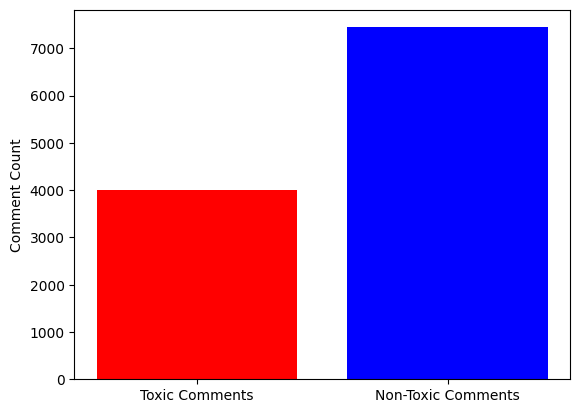

In [33]:
# Count toxic and non-toxic comments
toxic_count = toxicity_train_df['union'].sum()
non_toxic_count = len(toxicity_train_df) - toxic_count

# Plot side-by-side bars for toxic and non-toxic comments
labels = ['Toxic Comments', 'Non-Toxic Comments']
counts = [toxic_count, non_toxic_count]

plt.bar(labels, counts, color=['red', 'blue'])
plt.ylabel('Comment Count')

plt.show()

# Union Dataset Wordcloud

***What are the most common toxic words in our Union Dataset?***

Union Dataset: Represents the union of Llama 7-b zero-shot labeling, and RoBERTa NLP model fine-tuned on Wikipedia comments on toxic Twitch comments

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


1          Nice thats my first time in Hasan Lifestream
5           hey guys I'm finally here early, I love you
8     HYPERPOGGER I was here on accident. Catching u...
12    @rythympnxa naber agam @HasanAbi izlemeye mi g...
16    hasL hasL hasL hasL hasRaid hasRaid hasL hasL ...
Name: comment_text, dtype: object


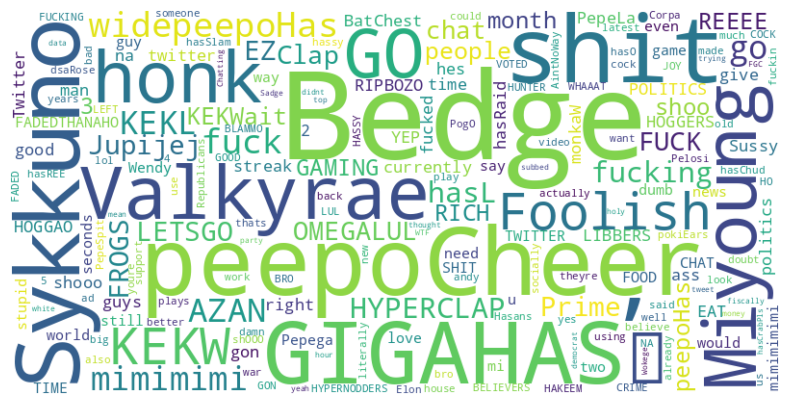

In [34]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import nltk
import pandas as pd
import string

# Download NLTK resources (run only once)
nltk.download('stopwords')
nltk.download('punkt')

# Filter toxic comments
toxic_comments = toxicity_train_df[toxicity_train_df['union'] == 1]['comment_text']
print(toxic_comments.head(5))

# Initialize NLTK stop words
stop_words = set(stopwords.words('english'))

# Extend the stop words list with additional common words to exclude
additional_stop_words = ['today', "don't", 'like', 'know', 'and', 'the',
                         'get', 'HasanAbi', 'hasanabi', 'Hasan', 'hasan', 'Abi',
                         'dont', ',', 'got', 'cant', 'make',
                         'see', 'im', 'make', 'think', 'one', 'every',
                         'take', 'day', 'really', 'Tier', 'tier', 'Tier 1',
                         '1', 'Theyve', 'theyve', 'going', 'subscribed', 'months']  # Add more words as needed
stop_words.update(additional_stop_words)

# Remove punctuation from comments
def remove_punctuation(text):
    return ''.join([char for char in text if char not in string.punctuation])

cleaned_comments = ' '.join([comment for comment in toxic_comments])
cleaned_comments = remove_punctuation(cleaned_comments)

# Tokenize the cleaned comments
tokens = nltk.word_tokenize(cleaned_comments)

# Remove stop words
tokens = [word for word in tokens if word.lower() not in stop_words]

# Calculate word frequencies
freq_dist = nltk.FreqDist(tokens)

# Generate the word cloud with frequencies
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(freq_dist)

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# Test Stream Word Cloud

Displays the test stream word cloud to visualize how the predictive the double fine-tuned model is (this is the before).

In [ ]:
# from wordcloud import WordCloud
# import matplotlib.pyplot as plt
# from nltk.corpus import stopwords
# import nltk
# import pandas as pd
# import string

# # Download NLTK resources (run only once)
# nltk.download('stopwords')
# nltk.download('punkt')

# # Filter toxic comments
# toxic_comments = toxicity_train_df[toxicity_train_df['union'] == 1]['comment_text']
# print(toxic_comments.head(5))

# # Initialize NLTK stop words
# stop_words = set(stopwords.words('english'))

# # Extend the stop words list with additional common words to exclude
# additional_stop_words = ['today', "don't", 'like', 'know', 'and', 'the',
#                          'get', 'HasanAbi', 'hasanabi', 'Hasan', 'hasan', 'Abi',
#                          'dont', ',', 'got', 'cant', 'make',
#                          'see', 'im', 'make', 'think', 'one', 'every',
#                          'take', 'day', 'really', 'Tier', 'tier', 'Tier 1',
#                          '1', 'Theyve', 'theyve', 'going', 'subscribed', 'months']  # Add more words as needed
# stop_words.update(additional_stop_words)

# # Remove punctuation from comments
# def remove_punctuation(text):
#     return ''.join([char for char in text if char not in string.punctuation])

# cleaned_comments = ' '.join([comment for comment in toxic_comments])
# cleaned_comments = remove_punctuation(cleaned_comments)

# # Tokenize the cleaned comments
# tokens = nltk.word_tokenize(cleaned_comments)

# # Remove stop words
# tokens = [word for word in tokens if word.lower() not in stop_words]

# # Calculate word frequencies
# freq_dist = nltk.FreqDist(tokens)

# # Generate the word cloud with frequencies
# wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(freq_dist)

# # Plot the word cloud
# plt.figure(figsize=(10, 5))
# plt.imshow(wordcloud, interpolation='bilinear')
# plt.axis('off')
# plt.show()

# Splitting & Labeling + Dataset creation



In [35]:
from torch.utils.data import Dataset, DataLoader
from transformers import RobertaTokenizer, RobertaModel

# Reset index to ensure consistency
toxicity_train_df.reset_index(drop=True, inplace=True)
toxicity_test_df.reset_index(drop=True, inplace=True)

# Select relevant columns from DataFrame and drop NaN values
train_data = toxicity_train_df[['comment_text', 'union']].dropna()
test_data = toxicity_test_df[['comment_text', 'toxic']].dropna()

# Extract features and labels
train_texts = train_data['comment_text'].tolist()
train_labels = train_data['union'].tolist()
test_texts = test_data['comment_text'].tolist()
test_labels = test_data['toxic'].tolist()

# Print examples of texts & labels
print("train_texts:")
print(train_texts[:5])
print("train_labels:")
print(train_labels[:5])
print("test_texts")
print(test_texts[:5])
print("test_labels:")
print(test_labels[:5])

# Split train data into train and validation sets
train_texts, val_texts, train_labels, val_labels = train_test_split(train_texts, train_labels, test_size=0.2)


class ToxicDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx]).float()
        return item

    def __len__(self):
        return len(self.labels)

tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
train_encodings = tokenizer(train_texts, truncation=True, padding=True)
val_encodings = tokenizer(val_texts, truncation=True, padding=True)
test_encodings = tokenizer(test_texts, truncation=True, padding=True)

train_dataset = ToxicDataset(train_encodings, train_labels)
val_dataset = ToxicDataset(val_encodings, val_labels)
test_dataset = ToxicDataset(test_encodings, test_labels)

print("Train Dataset")
# Iterate over train_dataset and print some samples
for i in range(2):  # Print first 2 samples
    sample = train_dataset[i]
    print(f"Sample {i + 1}:")
    # Convert input_ids tensor to list and access its keys
    encoding_keys = tokenizer.convert_ids_to_tokens(sample["input_ids"].tolist())
    print("Encoding keys:", encoding_keys)  # Print keys of encoding
    print("Label:", sample["labels"].item())  # Print label
    print()

print("Val Dataset")
# Iterate over val dataset and print some samples
for i in range(2):  # Print first 2 samples
    sample = val_dataset[i]
    print(f"Sample {i + 1}:")
    # Convert input_ids tensor to list and access its keys
    encoding_keys = tokenizer.convert_ids_to_tokens(sample["input_ids"].tolist())
    print("Encoding keys:", encoding_keys)  # Print keys of encoding
    print("Label:", sample["labels"].item())  # Print label
    print()

print("Test Dataset")
# Iterate over test dataset and print some samples
for i in range(2):  # Print first 2 samples
    sample = test_dataset[i]
    print(f"Sample {i + 1}:")
    # Convert input_ids tensor to list and access its keys
    encoding_keys = tokenizer.convert_ids_to_tokens(sample["input_ids"].tolist())
    print("Encoding keys:", encoding_keys)  # Print keys of encoding
    print("Label:", sample["labels"].item())  # Print label
    print()

train_texts:
["Confused why people are spamming things like Jupijej or Jupijej ? You can't see the emotes! Download the Jupijej browser extension to improve your chat experience! Jupijej", 'Nice thats my first time in Hasan Lifestream', 'THE ONE PIECE IS REAL LETSGO NEWS TODAY LETSGO', 'Dont forget to check ur cocks before stream starts', 'THE HASANABI IS REAL LETSGO THE HASANABI IS REAL LETSGO']
train_labels:
[0, 1, 0, 0, 0]
test_texts
['BS !', 'Hodad...does your user handle refer to your daughter??', "Many of them were wearing red Na'i Aupuni shirts.  Does that not show support for federal recognition?", '"Methinks your comment is indicative of your need to understand the Christian faith which does not require the subservience of woman as much as care and love for them by the man - ""as Christ loved the church""."', "And sometimes it's just salting the earth..."]
test_labels:
[0.0, 0.0, 0.0, 0.0, 0.0]
Train Dataset
Sample 1:
Encoding keys: ['<s>', 'who', 'Ġdo', 'Ġyou', 'Ġwant', 'Ġto'

# Training on Union

In [36]:
from torch.utils.data import DataLoader
from transformers import RobertaTokenizer, AutoModelForSequenceClassification
from transformers import AdamW
import torch

random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model = AutoModelForSequenceClassification.from_pretrained('/usr/fine_tuned_roberta_model')
model.to(device)
model.train()

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

optim = AdamW(model.parameters(), lr=1e-6)

num_train_epochs = 1
for epoch in range(num_train_epochs):
  total_loss = 0.0
  for batch_idx, batch in enumerate(train_loader):
      optim.zero_grad()
      input_ids = batch['input_ids'].to(device)
      attention_mask = batch['attention_mask'].to(device)
      labels = batch['labels'].to(device)

      outputs = model(input_ids, attention_mask=attention_mask, labels=labels)

      loss = outputs[0]
      total_loss += loss.item()

      loss.backward()
      optim.step()

      if (batch_idx + 1) % 20 == 0:  # Print progress every 20 batches
          print(f"Epoch [{epoch + 1}/{num_train_epochs}], Batch [{batch_idx + 1}/{len(train_loader)}], Loss: {total_loss / (batch_idx + 1):.4f}")

  print(f"Epoch [{epoch + 1}/{num_train_epochs}], Average Loss: {total_loss / len(train_loader):.4f}")

model.eval()

model.save_pretrained('/usr/fine_tuned_roberta_model_union')

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch [1/1], Batch [20/573], Loss: 0.2408
Epoch [1/1], Batch [40/573], Loss: 0.2384
Epoch [1/1], Batch [60/573], Loss: 0.2305
Epoch [1/1], Batch [80/573], Loss: 0.2329
Epoch [1/1], Batch [100/573], Loss: 0.2325
Epoch [1/1], Batch [120/573], Loss: 0.2329
Epoch [1/1], Batch [140/573], Loss: 0.2343
Epoch [1/1], Batch [160/573], Loss: 0.2323
Epoch [1/1], Batch [180/573], Loss: 0.2319
Epoch [1/1], Batch [200/573], Loss: 0.2306
Epoch [1/1], Batch [220/573], Loss: 0.2308
Epoch [1/1], Batch [240/573], Loss: 0.2311
Epoch [1/1], Batch [260/573], Loss: 0.2286
Epoch [1/1], Batch [280/573], Loss: 0.2273
Epoch [1/1], Batch [300/573], Loss: 0.2269
Epoch [1/1], Batch [320/573], Loss: 0.2279
Epoch [1/1], Batch [340/573], Loss: 0.2281
Epoch [1/1], Batch [360/573], Loss: 0.2283
Epoch [1/1], Batch [380/573], Loss: 0.2280
Epoch [1/1], Batch [400/573], Loss: 0.2271
Epoch [1/1], Batch [420/573], Loss: 0.2264
Epoch [1/1], Batch [440/573], Loss: 0.2266
Epoch [1/1], Batch [460/573], Loss: 0.2272
Epoch [1/1], Ba

# Fine-tuned Union (RoBERTa / Llama) Predictions

In [44]:
import pandas as pd
import numpy as np
from transformers import RobertaTokenizer, AutoModelForSequenceClassification
import torch
import random
from better_profanity import profanity

# Set a fixed state for randomness
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)  # If using CUDA

# Load the tokenizer and model for inference
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
model = AutoModelForSequenceClassification.from_pretrained('/usr/fine_tuned_roberta_model_union')

# Move the model to CPU if it's on CUDA device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

# Put the model in evaluation mode
model.eval()

# Function to convert LABEL_0 to 'no'
def convert_label(prediction):
    return 'no' if prediction[0]['label'] == 'LABEL_0' else 'yes'

def contains_profanity(text):
    return profanity_check.predict([text])[0]

global count
global sub_mention
# global profanity
sub_mention = False
profanity_in = False
count = 0

def predict_label(row):
    global count
    global sub_mention
    # global profanity
    text_to_predict = row['comment']
    sub_mention = any(keyword in text_to_predict for keyword in ["Tier 1", "subscribed with Prime", "subbed using Prime"])
    profanity_in = profanity.contains_profanity(text_to_predict)
    # if(count <100):
    #   print(text_to_predict)
    encoding = tokenizer(text_to_predict, return_tensors='pt', padding=True, truncation=True)
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)
    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
    logits = outputs.logits
    probabilities = torch.sigmoid(logits).cpu().numpy().flatten()
    # if(count <100):
    #   print(probabilities)
    # Convert probabilities to binary labels
    binary_label = 1 if profanity_in or (np.abs(probabilities[0]) > 0.58738 and not sub_mention) else 0
    count = count + 1
    if (count % 500 == 0):
      print(count)
    if(count < 80):
      print(np.abs(probabilities[0]))
      print(text_to_predict)
      print(binary_label)
    # if (binary_label == 1):
    #   print(text_to_predict)
    # print(binary_label)
    return binary_label

# Load the Twitch dataset
twitch_df = pd.read_csv('hasan_abi_11.19.22_test.csv')
print(len(twitch_df))

# Apply the prediction function to each row in the DataFrame
twitch_df['union_prediction'] = twitch_df.apply(predict_label, axis=1)

# Display the DataFrame with predictions
# print(twitch_df[['comment', 'union_prediction']])

# Assuming 'LABEL_0' corresponds to 'no'
prediction_counts = twitch_df['union_prediction'].value_counts()
print(prediction_counts)

# Print the counts
print("Count of 'no':", prediction_counts[0.0])
print("Count of 'yes':", prediction_counts[1.0])  # Adjust the label if needed

17480
0.60958564
Drake STUNLOCK FREE SATURDAY Drake NO 31 YEAR OLD MAN YELLING AT TROLLS Drake ONLY FUN REACTS AND GAMES Drake 󠀀
1
0.5877278
@HORSTBEFEHL D: how dare u call smol bear a stinky
1
0.56104463
LETSGO REFRESH LETSGO REFRESH LETSGO REFRESH LETSGO REFRESH LETSGO REFRESH LETSGO REFRESH LETSGO REFRESH LETSGO REFRESH
0
0.57789415
SHE BE JEJING MY JUPI Jupijej Jupijej Jupijej
0
0.5874908
peepoHey Hey Chat I hope you're having a great weekend peepoKiss
1
0.58730346
I hope everyone is having a great day hasL
0
0.58744544
@elhijodejackslid if you ever see me say live, I'm not trolling :P
1
0.57874084
SHE  BE JEJING MY JUPI Jupijej Jupijej Jupijej
0
0.58726215
Was not expecting to be here so soon
0
0.58738446
LEFTERS STRIMMER LIVE LEFTERS STRIMMER LIVE LEFTERS STRIMMER LIVE LEFTERS STRIMMER LIVE LEFTERS STRIMMER LIVE LEFTERS STRIMMER LIVE LEFTERS STRIMMER LIVE LEFTERS STRIMMER LIVE LEFTERS STRIMMER LIVE LEFTERS STRIMMER LIVE
1
0.5874794
SEE YOU ON THE OTHER SIDE OFFLINERS hasL hasL ha

In [47]:
# Define the file path for the Excel file
excel_file_path = "/usr/roberta_union_predictions.xlsx"

# Save the 'roberta_wiki_prediction' column to an Excel file
twitch_df['union_prediction'].to_excel(excel_file_path, index=False)

# Double fine-tuned WordCloud

0    Drake STUNLOCK FREE SATURDAY Drake NO 31 YEAR ...
1    @HORSTBEFEHL D: how dare u call smol bear a st...
4    peepoHey Hey Chat I hope you're having a great...
6    @elhijodejackslid if you ever see me say live,...
9    LEFTERS STRIMMER LIVE LEFTERS STRIMMER LIVE LE...
Name: comment, dtype: object


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

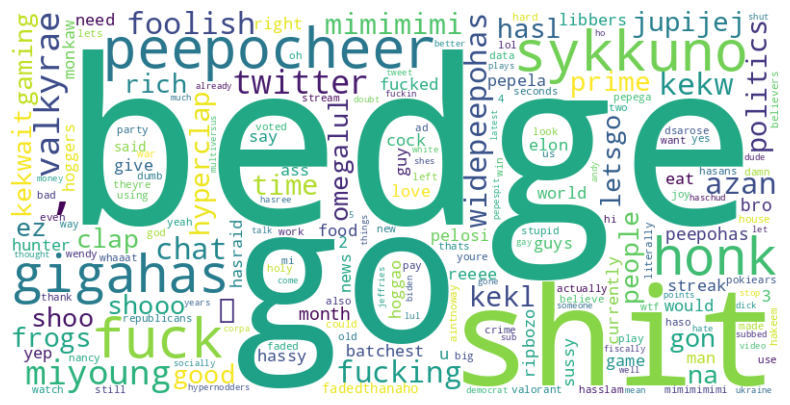

In [46]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import nltk
import pandas as pd
import string

# Download NLTK resources (run only once)
nltk.download('stopwords')
nltk.download('punkt')

# Filter toxic comments
toxic_comments = twitch_df[twitch_df['union_prediction'] == 1]['comment']
print(toxic_comments.head(5))

# batch_size = 1000  # Set the batch size
# num_rows = len(twitch_df)
# with open('union_output.txt', 'w') as f:
#     for start in range(0, num_rows, batch_size):
#         end = min(start + batch_size, num_rows)
#         for index, row in twitch_df.iloc[start:end].iterrows():
#             f.write(str(row['union_prediction']) + '\n')

from google.colab import files
files.download('union_output.txt')

# Initialize NLTK stop words
stop_words = set(stopwords.words('english'))

# Extend the stop words list with additional common words to exclude
additional_stop_words = ['today', "don't", 'like', 'know', 'and', 'the',
                         'get', 'HasanAbi', 'hasanabi', 'Hasan', 'hasan', 'Abi',
                         'dont', ',', 'got', 'cant', 'make', 'hes', 'back',
                         'see', 'im', 'make', 'think', 'one', 'every', 'running',
                         'take', 'day', 'really', 'Trump', 'EPISODE', 'PODCAST', 'Episode',
                         'Podcast', 'leftovers', 'trump', 'episode', 'podcast']  # Add more words as needed
stop_words.update(additional_stop_words)

# Remove punctuation from comments
def remove_punctuation(text):
    return ''.join([char for char in text if char not in string.punctuation])

cleaned_comments = ' '.join([comment for comment in toxic_comments])
cleaned_comments = remove_punctuation(cleaned_comments)

# Convert all words to lowercase before removing stopwords
tokens = [word.lower() for word in tokens]

# Remove stop words
tokens = [word for word in tokens if word not in stop_words]

# Calculate word frequencies
freq_dist = nltk.FreqDist(tokens)

# Generate the word cloud with frequencies
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(freq_dist)

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()
